In [111]:
# 311 Classification Model: Predict Service Type

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
# === Load Filtered Dataset (2023–2025 only) ===
df = pd.read_csv("311_filtered_2023_2025.csv")
df.head()

,service_request_id,requested_date,updated_date,closed_date,status_description,source,service_name,agency_responsible,address,comm_code,comm_name,location_type,longitude,latitude,point,year
0,24-00502646,2024-06-27,2024/06/28 12:00:00 AM,2024/06/28 12:00:00 AM,Closed,Other,CT - Lost Property,OS - Calgary Transit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
1,23-00740795,2023-10-03,2023/10/16 12:00:00 AM,2023/10/16 12:00:00 AM,Closed,App,Parks - Tree Concern - WAM,OS - Parks and Open Spaces,NaN,BOW,BOWNESS,Community Centrepoint,-114.188388,51.083346,POINT (-114.18838847472 51.083346287717),2023
2,23-00384313,2023-05-30,2023/07/18 12:00:00 AM,2023/07/18 12:00:00 AM,Closed,Phone,Corporate - Graffiti Concerns,CS - Emergency Management and Community Safety,NaN,RCK,ROSSCARROCK,Community Centrepoint,-114.145486,51.043288,POINT (-114.145485909296 51.043287871375),2023
3,23-00740946,2023-10-03,2023/10/16 12:00:00 AM,2023/10/16 12:00:00 AM,Closed,Phone,WATS - Water Off-On Appointment,OS - Water Services,NaN,HAY,HAYSBORO,Community Centrepoint,-114.083340,50.972215,POINT (-114.083340239542 50.972214842335),2023
4,24-00504566,2024-06-27,2024/07/04 12:00:00 AM,2024/07/04 12:00:00 AM,Closed,Other,WATS - Cross Connection Tester Support - ONLINE,OS - Water Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024


In [115]:
# === Feature Engineering ===
df['requested_date'] = pd.to_datetime(df['requested_date'], errors='coerce')
df['hour'] = df['requested_date'].dt.hour
df['weekday'] = df['requested_date'].dt.dayofweek
df['month'] = df['requested_date'].dt.month

In [117]:
df = df.dropna(subset=['service_name', 'source', 'comm_name'])

top_n = 20
top_services = df['service_name'].value_counts().nlargest(top_n)
print("Top 20 Service Types:\n")
print(top_services)

Top 20 Service Types:

service_name
WRS - Cart Management                      56174
Finance - Property Tax Account Inquiry     37421
Bylaw - Snow and Ice on Sidewalk           37322
AT - Property Tax Account Inquiry          27125
Finance - ONLINE TIPP Agreement Request    26035
Corporate - Graffiti Concerns              23984
Roads - Pothole Maintenance                21939
Roads - Snow and Ice Control               20818
311 Contact Us                             20414
Bylaw - Material on Public Property        18815
WRS - Compost - Green Cart                 17827
WRS - Waste - Residential                  17801
WRS - Recycling - Blue Cart                17770
Bylaw - Long Grass - Weeds Infraction      17161
WRS - New Service - Carts                  17012
Corporate - Encampment Concerns            16789
Roads - Streetlight Maintenance            16501
WATS - Sewage Back-up                      15538
Parks - Tree Concern - WAM                 15021
Parks - Tree Concern - GIS       

In [119]:
# Keep only the top 20 most frequent service types
top_n = 20
top_services = df['service_name'].value_counts().nlargest(top_n).index
df = df[df['service_name'].isin(top_services)].copy()

In [121]:
# === Encode Categorical Features ===
le_source = LabelEncoder()
le_comm = LabelEncoder()
le_service = LabelEncoder()

df['source_enc'] = le_source.fit_transform(df['source'])
df['comm_enc'] = le_comm.fit_transform(df['comm_name'])
df['service_enc'] = le_service.fit_transform(df['service_name'])
df.head()

,service_request_id,requested_date,updated_date,closed_date,status_description,source,service_name,agency_responsible,address,comm_code,...,longitude,latitude,point,year,hour,weekday,month,source_enc,comm_enc,service_enc
1,23-00740795,2023-10-03,2023/10/16 12:00:00 AM,2023/10/16 12:00:00 AM,Closed,App,Parks - Tree Concern - WAM,OS - Parks and Open Spaces,NaN,BOW,...,-114.188388,51.083346,POINT (-114.18838847472 51.083346287717),2023,0,1,10,0,64,10
2,23-00384313,2023-05-30,2023/07/18 12:00:00 AM,2023/07/18 12:00:00 AM,Closed,Phone,Corporate - Graffiti Concerns,CS - Emergency Management and Community Safety,NaN,RCK,...,-114.145486,51.043288,POINT (-114.145485909296 51.043287871375),2023,0,1,5,2,237,6
8,23-00111641,2023-02-16,2023/05/08 12:00:00 AM,2023/05/08 12:00:00 AM,Closed,App,Roads - Streetlight Maintenance,TRAN - Roads,NaN,ALB,...,-113.996778,51.044531,POINT (-113.996778085137 51.044530587467),2023,0,3,2,0,44,13
21,23-00461488,2023-06-22,2023/07/18 12:00:00 AM,2023/07/18 12:00:00 AM,Closed,App,Parks - Tree Concern - WAM,OS - Parks and Open Spaces,NaN,MCT,...,-113.961479,50.917145,POINT (-113.961478654017 50.917144987538),2023,0,3,6,0,188,10
38,23-00274508,2023-04-22,2023/05/08 12:00:00 AM,2023/05/08 12:00:00 AM,Closed,Other,WRS - New Service - Carts,UEP - Waste and Recycling Services,NaN,CRA,...,-113.979992,50.878202,POINT (-113.979991517887 50.878202389903),2023,0,5,4,1,96,17


In [123]:
# === Prepare Data for Modeling with Stratified Sampling ===
X = df[['source_enc', 'comm_enc', 'hour', 'weekday', 'month']]
y = df['service_enc']

# Use stratified sampling to preserve class distribution
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

In [125]:
# === Train Classifier ===
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [127]:
# === Evaluate Model ===
import numpy as np

y_pred = clf.predict(X_test)

# Make sure to match actual labels present in y_test
present_labels = np.unique(y_test)
present_names = le_service.inverse_transform(present_labels)

print("Classification Report:")
print(classification_report(y_test, y_pred, labels=present_labels, target_names=present_names))

Classification Report:
                                         precision    recall  f1-score   support

                         311 Contact Us       0.23      0.18      0.20      4083
      AT - Property Tax Account Inquiry       0.18      0.17      0.18      5425
  Bylaw - Long Grass - Weeds Infraction       0.30      0.33      0.31      3432
    Bylaw - Material on Public Property       0.17      0.10      0.13      3763
       Bylaw - Snow and Ice on Sidewalk       0.38      0.54      0.45      7464
        Corporate - Encampment Concerns       0.26      0.23      0.24      3358
          Corporate - Graffiti Concerns       0.33      0.39      0.36      4797
Finance - ONLINE TIPP Agreement Request       0.26      0.29      0.28      5207
 Finance - Property Tax Account Inquiry       0.35      0.35      0.35      7484
             Parks - Tree Concern - GIS       0.17      0.12      0.14      2969
             Parks - Tree Concern - WAM       0.14      0.09      0.11      3004
    

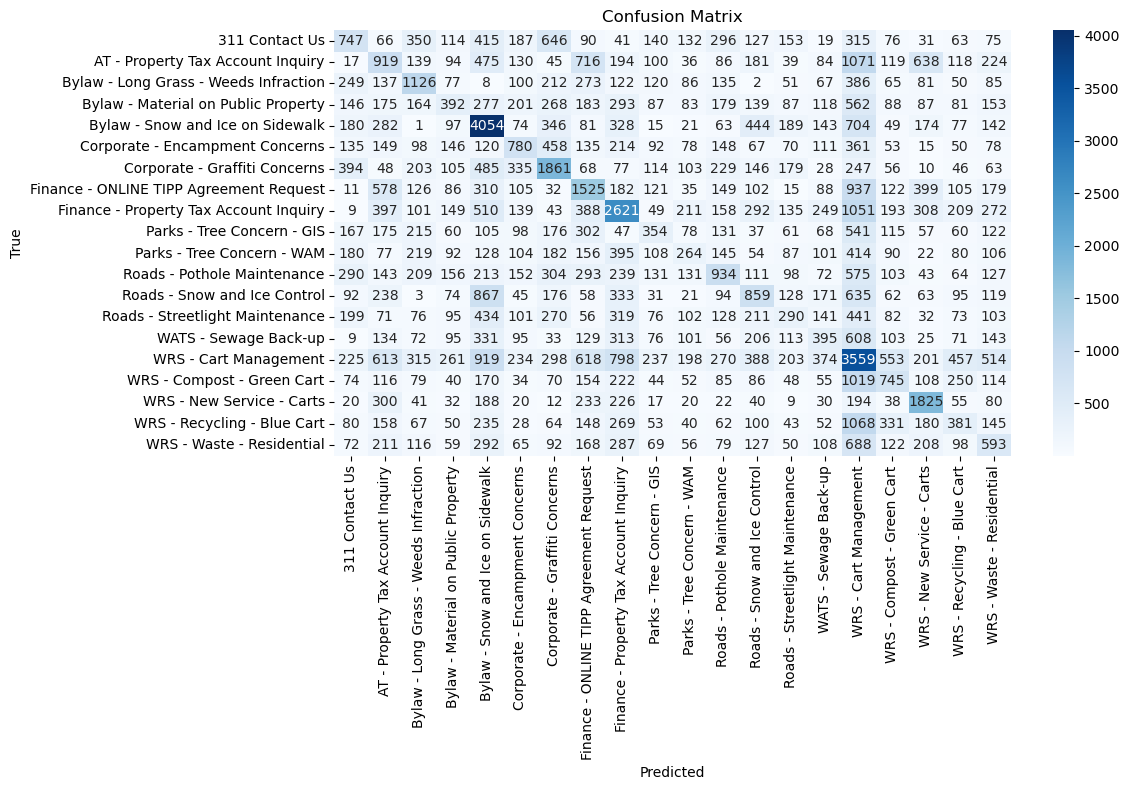

In [129]:
# === Confusion Matrix ===
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_service.classes_, yticklabels=le_service.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

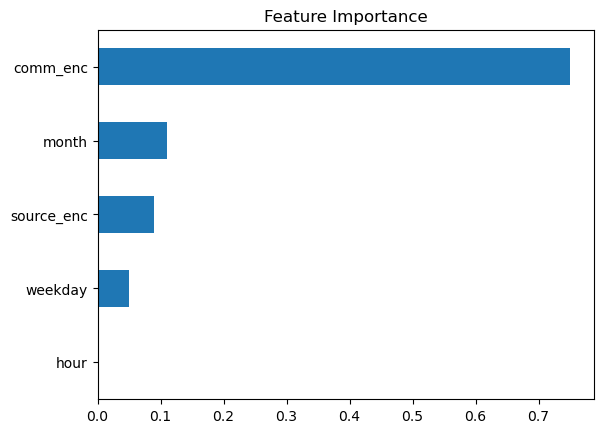

['rf_classifier.pkl']

In [131]:
# === Feature Importance ===
feat_importance = pd.Series(clf.feature_importances_, index=X.columns)
feat_importance.sort_values().plot(kind='barh', title='Feature Importance')
plt.show()

# === Save Encoders for Deployment ===
import joblib
joblib.dump(le_source, "le_source.pkl")
joblib.dump(le_comm, "le_comm.pkl")
joblib.dump(le_service, "le_service.pkl")
joblib.dump(clf, "rf_classifier.pkl")

# 🧠 311 Service Request Classifier
Use the form below to predict the service type based on source, community, and time.


In [134]:
import joblib
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Load encoders and model
clf = joblib.load("rf_classifier.pkl")
le_source = joblib.load("le_source.pkl")
le_comm = joblib.load("le_comm.pkl")
le_service = joblib.load("le_service.pkl")

# Widgets
source_widget = widgets.Dropdown(options=le_source.classes_, description='Source:')
comm_widget = widgets.Dropdown(options=le_comm.classes_, description='Community:')
hour_widget = widgets.IntSlider(value=12, min=0, max=23, description='Hour')
weekday_widget = widgets.Dropdown(options=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], description='Weekday')
month_widget = widgets.IntSlider(value=6, min=1, max=12, description='Month')

button = widgets.Button(description="Predict")
output = widgets.Output()

weekday_map = {"Mon": 0, "Tue": 1, "Wed": 2, "Thu": 3, "Fri": 4, "Sat": 5, "Sun": 6}

def on_button_clicked(b):
    with output:
        output.clear_output()
        X = pd.DataFrame([[
            le_source.transform([source_widget.value])[0],
            le_comm.transform([comm_widget.value])[0],
            hour_widget.value,
            weekday_map[weekday_widget.value],
            month_widget.value
        ]], columns=['source_enc', 'comm_enc', 'hour', 'weekday', 'month'])

        pred = clf.predict(X)[0]
        pred_name = le_service.inverse_transform([pred])[0]
        print(f"🔮 Predicted Service Type: **{pred_name}**")

button.on_click(on_button_clicked)

# Display widgets
display(source_widget, comm_widget, hour_widget, weekday_widget, month_widget, button, output)


Dropdown(description='Source:', options=('App', 'Other', 'Phone', 'Web'), value='App')

Dropdown(description='Community:', options=('01B', '01C', '01F', '01H', '01I', '01K', '02B', '02C', '02E', '02…

IntSlider(value=12, description='Hour', max=23)

Dropdown(description='Weekday', options=('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), value='Mon')

IntSlider(value=6, description='Month', max=12, min=1)

Button(description='Predict', style=ButtonStyle())

Output()

---

### 📌 Notes:
- This interactive prediction tool uses a trained Random Forest model to classify 311 service requests.
- Simply select **Source**, **Community**, **Hour**, **Weekday**, and **Month**, then click **Predict**.
- The model uses encoded categorical features and was trained on filtered data from 2023–2025.

_This section is only for selecting the above features._

---



<br><br><br><br><br><br><br><br><br><br>

<br><br><br><br><br><br><br><br><br><br>